In [6]:
import time
import math, os

from coffea.nanoevents import BaseSchema

import awkward as ak
import numpy as np
from coffea import processor

from hist import Hist

from coffea.nanoevents.methods import candidate
ak.behavior.update(candidate.behavior)

import matplotlib.pyplot as plt

In [7]:
## Particle collections

# Gen particle collections
gen_part_cols = ['GenPart_eta', 'GenPart_genPartIdxMother', 'GenPart_mass', 'GenPart_pdgId', "GenPart_phi", "GenPart_pt", 'GenPart_status',
                 'GenPart_Id', 'GenPart_parpdgId', 'GenPart_sparpdgId', 'GenPart_numberOfDaughters', 'GenPart_nstchgdaug', 'GenPart_vx', 
                 'GenPart_vy', 'GenPart_vz', 'GenPart_mvx', 'GenPart_mvy', 'GenPart_mvz', 'GenPart_recIdx']

# Muon collections
muon_cols = ['Muon_charge', 'Muon_dxy', 'Muon_dxyErr', 'Muon_dz', 'Muon_dzErr', 'Muon_eta', 'Muon_isGlobal', 'Muon_mass',
             'Muon_phi', 'Muon_pt', 'Muon_ptErr', 'Muon_softId', 'Muon_vtxIdx', 'Muon_vtxFlag', 'Muon_simIdx']

# Dimuon collections
dimu_cols = ['Dimu_pt', 'Dimu_eta', 'Dimu_phi', 'Dimu_rap', 'Dimu_mass', 'Dimu_charge', 'Dimu_vtxIdx', 'Dimu_chi2', 'Dimu_dl',
             'Dimu_dlErr', 'Dimu_dlSig', 'Dimu_cosphi', 'Dimu_x', 'Dimu_y', 'Dimu_z', 'Dimu_t1muIdx', 'Dimu_t2muIdx',]


# Function to get the collections
def get_vars_dict(events, col_list):
    dict = {}
    col = ''
    for c in col_list:
        if c.startswith('Muon'):
            col = c[5:]
        elif c.startswith('Dimu'):
            col = c[4:]
            if col.startswith('_'): col = col[1:]
        elif c.startswith('D0'):
            col = c[2:]
            if col.startswith('_'): col = col[1:]
        elif c.startswith('Dstar'):
            col = c[5:]
            if col.startswith('_'): col = col[1:]
        elif c.startswith('PVtx'):
            col = c[5:]
        elif c.startswith("GenPart"):
            col = c[8:]
        else:
            Exception('Not good!')

        if col == 'x' or col == 'y' or col == 'z':
            col = 'vtx_' + col

        if len(events[c]) == 0:
            dict[col] = np.array([])
        else:
            dict[col] = events[c]
    return dict

In [8]:
import re

files = []
# Uses scandir to iterate over the root files
with os.scandir("/eos/user/m/mabarros/Monte_Carlo/jpsi_gun/0000") as it:
    # Iterates over the files
    for file in it:
        if file.name.endswith('.root') and (file.stat().st_size != 0):
            # Stores the file
            files.append(file.path)

## Code block to sort file names
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]
            
files.sort(key=natural_keys)

In [9]:
import matplotlib.pyplot as plt
import mplhep
from matplotlib.text import Text
from hist.intervals import ratio_uncertainty

plt.style.use(mplhep.style.CMS)
    
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14
})

In [10]:
def acceptance_plot(hist_reco, hist_gen, ax=None, with_labels=True):

    ratio = hist_reco / hist_gen.values()

    if with_labels:
        err_down, err_up = ratio_uncertainty(hist_reco.values(), hist_gen.values())
        labels = []
        for ra, u, d in zip(ratio.values().ravel(), err_up.ravel(), err_down.ravel()):
            ra, u, d = f'{ra:.2f}', f'{u:.2f}', f'{d:.2f}'
            st = '$'+ra+'_{-'+d+'}^{+'+u+'}$'
            labels.append(st)
        labels = np.array(labels).reshape(10,10)

        mplhep.hist2dplot(ratio, labels=labels, ax=ax)

        x = ax.get_children()
        for i0 in x:
            if isinstance(i0, Text):
                i0.set_size(10)

        return ax
    else:
        mplhep.hist2dplot(ratio, ax=ax)
        return ax

In [44]:
class AcceptanceProcessor(processor.ProcessorABC):
    def __init__(self):
        Gen_Jpsi_hists = {
            'Gen_Jpsi_pt': Hist.new.Reg(100, 0, 100, name='pt', label=r"$p_{T,\mu^+\mu^-}$ [GeV]").Double(),
            'Gen_Jpsi_eta': Hist.new.Reg(60, -4, 4, name="eta", label=r"$\eta_{\mu^+\mu^-}$").Double(),
            'Gen_Jpsi_phi': Hist.new.Reg(60, -math.pi, math.pi, name="phi", label=r"$\phi_{\mu^+\mu^-}$").Double(),
            
            'Gen_Jpsi_pt_0to100_x_eta-4to4': (
                Hist.new
                .Reg(10, 0, 100, name='pt', label=r"$p_{T,\mu^+\mu^-}$ [GeV]")
                .Reg(10, -4, 4, name="eta", label=r"$\eta_{\mu^+\mu^-}$")
                .Double()
                ),
            
            'Gen_Jpsi_pt_0to10_x_eta-2p5to2p5': (
                Hist.new
                .Reg(10, 0, 10, name='pt', label=r"$p_{T,\mu^+\mu^-}$ [GeV]")
                .Reg(10, -2.5, 2.5, name="eta", label=r"$\eta_{\mu^+\mu^-}$")
                .Double()
                ), 
            
        }

        Reco_Jpsi_hists = {
            'Reco_Jpsi_pt': Hist.new.Reg(100, 0, 100, name='pt', label=r"$p_{T,\mu^+\mu^-}$ [GeV]").Double(),
            'Reco_Jpsi_eta': Hist.new.Reg(60, -4, 4, name="eta", label=r"$\eta_{\mu^+\mu^-}$").Double(),
            'Reco_Jpsi_phi': Hist.new.Reg(60, -math.pi, math.pi, name="phi", label=r"$\phi_{\mu^+\mu^-}$").Double(),
           
            'Reco_Jpsi_pt_0to100_x_eta-4to4': (
                Hist.new
                .Reg(10, 0, 100, name='pt', label=r"$p_{T,\mu^+\mu^-}$ [GeV]")
                .Reg(10, -4, 4, name="eta", label=r"$\eta_{\mu^+\mu^-}$")
                .Double()
                ),
            'Reco_Jpsi_pt_0to10_x_eta-2p5to2p5': (
                Hist.new
                .Reg(10, 0, 10, name='pt', label=r"$p_{T,\mu^+\mu^-}$ [GeV]")
                .Reg(10, -2.5, 2.5, name="eta", label=r"$\eta_{\mu^+\mu^-}$")
                .Double()
                ),
        }
        
        self._hists = {
            'Gen_Jpsi': {**Gen_Jpsi_hists},
            'Reco_Jpsi': {**Reco_Jpsi_hists},
        }
        
        self._accumulator = processor.dict_accumulator({
            'details': processor.defaultdict_accumulator(int),
        })
        
        
    @property
    def accumulator(self):
        return self._accumulator
    
    @property
    def hists(self):
        return self._hists

    def process(self, events):
        output = self.accumulator.identity()
        
        # test if there is any events in the file
        if len(events) == 0:
            return output

        # Collection extraction
        GenPart = ak.zip({**get_vars_dict(events, gen_part_cols)}, with_name="PtEtaPhiMCandidate")
        
        # Dimuon collection
        Dimus = ak.zip({**get_vars_dict(events, dimu_cols)}, with_name="PtEtaPhiMCandidate")
        
        ## Rec dimuon cuts
        
        #Dimu cuts charge = 0, mass cuts and chi2...
        Dimu = Dimus[Dimus.charge == 0]

        Dimu = Dimu[(Dimu.mass > 2.95) & (Dimu.mass < 3.25)]

        # Get the Muons from Dimu, for cuts in their params
        #Muon = ak.zip({'0': Muons[Dimu.t1muIdx], '1': Muons[Dimu.t2muIdx]})
       
        # Takes all gen jpsi
        gen_dimu = GenPart[GenPart.pdgId == 443]
                
        # Takes all gen muons
        gen_muon = GenPart[np.absolute(GenPart.pdgId) == 13]
        
        ## Gen muon cuts  
        
        # Takes gen muon with the same mother
        gen_muon = ak.combinations(gen_muon, 2)
        same_mother = ((gen_muon.slot0.genPartIdxMother == gen_muon.slot1.genPartIdxMother) & (gen_muon.slot0.parpdgId == 443))                       
        gen_muon = gen_muon[same_mother]
        
        self.hists['Gen_Jpsi']['Gen_Jpsi_pt_0to100_x_eta-4to4'].fill(
            pt=ak.flatten(gen_dimu.pt),
            eta=ak.flatten(gen_dimu.eta)
        )
        self.hists['Reco_Jpsi']['Reco_Jpsi_pt_0to100_x_eta-4to4'].fill(
            pt=ak.flatten(Dimu.pt),
            eta=ak.flatten(Dimu.eta)
        )
        
        self.hists['Gen_Jpsi']['Gen_Jpsi_pt_0to10_x_eta-2p5to2p5'].fill(
            pt=ak.flatten(gen_dimu.pt),
            eta=ak.flatten(gen_dimu.eta)
        )
        self.hists['Reco_Jpsi']['Reco_Jpsi_pt_0to10_x_eta-2p5to2p5'].fill(
            pt=ak.flatten(Dimu.pt),
            eta=ak.flatten(Dimu.eta)
        )
        
    
        return self.hists

    def postprocess(self, accumulator):
        return accumulator

In [46]:
data = {"test": files[0:100]}

tstart = time.time()

output = processor.run_uproot_job(data,
                                    treename='Events',
                                    processor_instance=AcceptanceProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={"schema": BaseSchema, 'workers': 8, 'skipbadfiles': True},
                                    chunksize=360000,
                                    )

""" hists = output[1]
output = output[0] """

print(f"Process finished in: {time.time() - tstart:.2f} s")
#print(output[0]['details'])

Preprocessing:   0%|          | 0/50 [00:00<?, ?file/s]

Processing:   0%|          | 0/100 [00:00<?, ?chunk/s]

Process finished in: 32.49 s


<AxesSubplot:xlabel='$p_{T,\\mu^+\\mu^-}$ [GeV]', ylabel='$\\eta_{\\mu^+\\mu^-}$'>

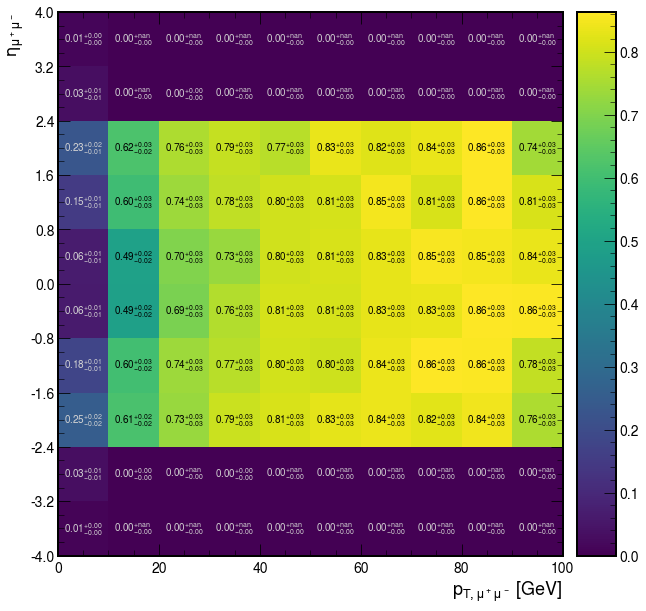

In [47]:
fig = plt.figure()
fig.clear()
ax = fig.add_subplot()
acceptance_plot(output['Reco_Jpsi']['Reco_Jpsi_pt_0to100_x_eta-4to4'], output['Gen_Jpsi']['Gen_Jpsi_pt_0to100_x_eta-4to4'], ax=ax)
#ax.set_xlabel(r"$p_{T,D^{*}}$ [GeV]")
#ax.set_ylabel(r"$\eta_{D^{*}}$")

<AxesSubplot:xlabel='$p_{T,\\mu^+\\mu^-}$ [GeV]', ylabel='$\\eta_{\\mu^+\\mu^-}$'>

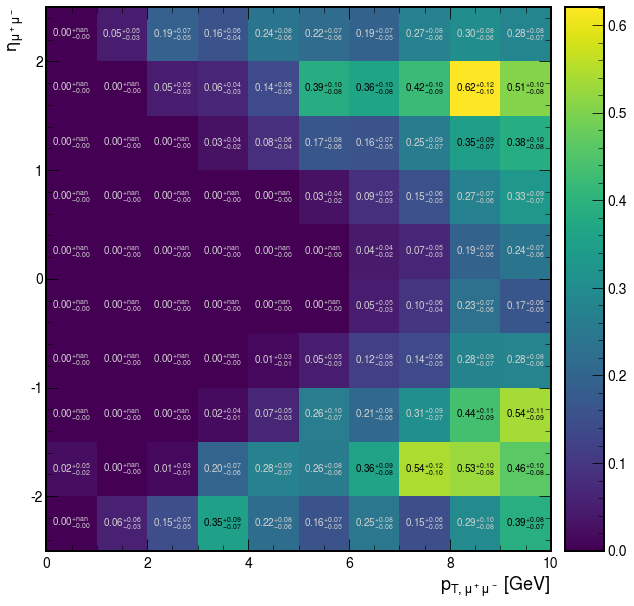

In [48]:
fig = plt.figure()
fig.clear()
ax = fig.add_subplot()
acceptance_plot(output['Reco_Jpsi']['Reco_Jpsi_pt_0to10_x_eta-2p5to2p5'], output['Gen_Jpsi']['Gen_Jpsi_pt_0to10_x_eta-2p5to2p5'], ax=ax)
#ax.set_xlabel(r"$p_{T,D^{*}}$ [GeV]")
#ax.set_ylabel(r"$\eta_{D^{*}}$")